# Exploration of DrugMechDB

Here, I explore [DrugMechDB](https://sulab.github.io/DrugMechDB/) which could ideally provide us with true positive paths / MOAs.

In [1]:
import pandas as pd
import os.path as osp
from collections import Counter
from urllib import request
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
import numpy as np
import math
import requests
from tqdm import tqdm

## Load in the DrugMechDB file:

In [2]:
VALIDATION_DIR = '../data/validation'

The database download comes as an excel file with many separate sheets, so it needs to be read in as separate dataframes:

In [5]:
!pip install --upgrade openpyxl

     |████████████████████████████████| 249 kB 3.3 MB/s eta 0:00:01    |████                            | 30 kB 1.9 MB/s eta 0:00:01
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.4
    Uninstalling openpyxl-3.0.4:
      Successfully uninstalled openpyxl-3.0.4


In [3]:
dm_db = pd.ExcelFile('s3://enveda-datascience/lauren/indication_MOA_paths.xlsx')
# dm_db.head()

In [4]:
indications = pd.read_excel(dm_db, 'sample_indications')

In [5]:
indications.head()

,name,num_ind_dc,db_id,comp_mesh_ids,disease_name,dis_mesh_id,Comments
0,imatinib,11.0,DB00619,MESH:D000068877,CML (ph+),MESH:D015464,"Multiple ways to represent this path, experime..."
1,imatinib,11.0,DB00619,MESH:D000068877,Systemic mast cell disease,MESH:D034721,NaN
2,imatinib,11.0,DB00619,MESH:D000068877,Systemic mast cell disease,MESH:D034721,NaN
3,acetaminophen,NaN,DB00316,MESH:D000082,Pain,MESH:D010146,"Multiple ways to represent this path, experime..."
4,acetaminophen,NaN,DB00316,MESH:D000082,Pain,MESH:D010146,NaN


We can see the the drugs are provided as [DrugBank](https://go.drugbank.com) identifiers, and the diseases are providued as [MeSh identifiers](https://www.nlm.nih.gov/mesh/meshhome.html). 

Let's look at the paths:

## Path Instances in DrugMechDB

In [6]:
paths = pd.read_excel(dm_db, 'paths')

In [7]:
paths.head()

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,imatinib,INHIBITS,BCR/ABL,CAUSES,CML (ph+),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,imatinib,INHIBITS,c-Kit,UP_REGULATES,Cellular proliferation,CAUSES,Systemic mast cell disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,imatinib,INHIBITS,Pdgf,UP_REGULATES,Cellular proliferation,CAUSES,Systemic mast cell disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,acetaminophen,INHIBITS,cycloxygenaze pathways,ASSOCIATED_WITH,Pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,acetaminophen,INHIBITS,Cox-1,PRODUCES,Prostaglandins,CAUSES,Pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


How long are most of the paths? I'll define the length of the paths as the number of edges/hops.

In [8]:
Counter([(row.count() - 1) / 2 for i, row in paths.iterrows()])

Counter({2.0: 13, 3.0: 38, 4.0: 59, 5.0: 8, 1.0: 3, 7.0: 1, 6.0: 1})

It looks like most are length 4.

Only 3 are above length 5.

What if we only take those which end in a biological process?

It might be better to work from the JSON file instead, which can be found [here](https://github.com/SuLab/DrugMechDB/blob/1.0/indication_paths.json). In contrast to the paths in the dataframe, the JSON version has the types for each node.

In [9]:
url = "https://raw.githubusercontent.com/SuLab/DrugMechDB/1.0/indication_paths.json"
filepath = "s3://enveda-datascience/lauren/drugmechdb_paths.json"

In [10]:
with request.urlopen(url) as fl:
    data_json = json.loads(fl.read())
    #json.dump(dict(data_json), filepath)
    #print(data_json)

Are there the same number of paths as before?

In [11]:
len(data_json)

123

In [12]:
len(data_json) == len(paths)

True

Let's take a look at an example path:

In [13]:
data_json[1]

{'directed': True,
 'multigraph': True,
 'graph': {'drug': 'imatinib',
  'disease': 'Systemic mast cell disease',
  'drugbank': 'DB00619',
  'drug_mesh': 'MESH:D000068877',
  'disease_mesh': 'MESH:D034721'},
 'nodes': [{'id': 'MESH:D000068877', 'name': 'imatinib', 'label': 'Drug'},
  {'id': 'UniProt:P10721', 'name': 'c-Kit', 'label': 'Protein'},
  {'id': 'GO:0008283',
   'name': 'Cellular proliferation',
   'label': 'Biological Process'},
  {'id': 'MESH:D034721',
   'name': 'Systemic mast cell disease',
   'label': 'Disease'}],
 'links': [{'source': 'MESH:D000068877',
   'target': 'UniProt:P10721',
   'key': 'INHIBITS'},
  {'source': 'UniProt:P10721', 'target': 'GO:0008283', 'key': 'UP_REGULATES'},
  {'source': 'GO:0008283', 'target': 'MESH:D034721', 'key': 'CAUSES'}]}

We can get the number of nodes involved:

In [14]:
len(data_json[1]['nodes'])

4

... and using that, get the second-to-last node (the last is always a disease).

In [15]:
data_json[1]['nodes'][len(data_json[1]['nodes']) - 2]

{'id': 'GO:0008283',
 'name': 'Cellular proliferation',
 'label': 'Biological Process'}

Cool, let's create a new object containing only those which end in a BP node.

Let's also get all the unique BPs involved:

In [16]:
bp_paths = []
bp_path_lengths = []
bps = set()
for path in data_json:
    # if second to last node is BP,
    if path['nodes'][len(path['nodes']) - 2]['label'] == 'Biological Process':
        bp_paths.append(path)
        bp_path_lengths.append(len(path['links']) - 1)
        bps.add(path['nodes'][len(path['nodes']) - 2]['id'])

How many of the 162 paths end in a BP?

In [17]:
len(bp_paths)

62

In [18]:
Counter(bp_path_lengths)

Counter({2: 25, 3: 24, 4: 7, 1: 6})

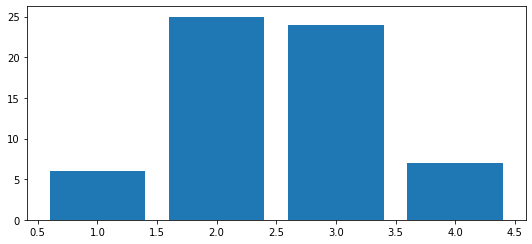

In [19]:
bpath_lens = Counter(bp_path_lengths)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.bar(bpath_lens.keys(), bpath_lens.values())

plt.show()

Now, it also looks like no paths ending in BP are longer than 5 edges.

How many unique BPs act as sink nodes here?

In [20]:
len(bps)

34

In [21]:
bp_paths[0]

{'directed': True,
 'multigraph': True,
 'graph': {'drug': 'imatinib',
  'disease': 'Systemic mast cell disease',
  'drugbank': 'DB00619',
  'drug_mesh': 'MESH:D000068877',
  'disease_mesh': 'MESH:D034721'},
 'nodes': [{'id': 'MESH:D000068877', 'name': 'imatinib', 'label': 'Drug'},
  {'id': 'UniProt:P10721', 'name': 'c-Kit', 'label': 'Protein'},
  {'id': 'GO:0008283',
   'name': 'Cellular proliferation',
   'label': 'Biological Process'},
  {'id': 'MESH:D034721',
   'name': 'Systemic mast cell disease',
   'label': 'Disease'}],
 'links': [{'source': 'MESH:D000068877',
   'target': 'UniProt:P10721',
   'key': 'INHIBITS'},
  {'source': 'UniProt:P10721', 'target': 'GO:0008283', 'key': 'UP_REGULATES'},
  {'source': 'GO:0008283', 'target': 'MESH:D034721', 'key': 'CAUSES'}]}

**It is worth noting that there are lots of non-drug compounds in here, such as carbovir triphosphate and prostaglandins, which act as middle players in the paths.**

What about any path in general which contains a BP?

In [22]:
bp_paths = []
bp_path_lengths = []
bps = set()
for path in data_json:
    for count, node in enumerate(path['nodes']):
    # if any node is BP,
        if node['label'] == 'Biological Process':
            bp_paths.append(path)
            bp_path_lengths.append(count)
            bps.add(path['nodes'][count]['id'])

In [23]:
len(bp_paths)

100

We have a lot more if we include BPs in the middle.

In [24]:
Counter(bp_path_lengths)

Counter({2: 60, 3: 25, 4: 9, 1: 6})

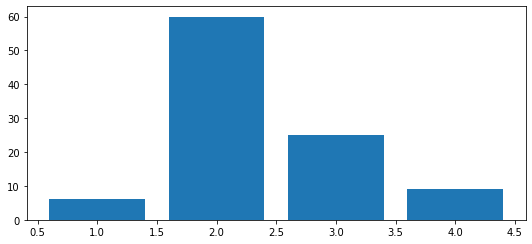

In [25]:
bpath_lens = Counter(bp_path_lengths)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.bar(bpath_lens.keys(), bpath_lens.values())

plt.show()

Now, we have a lot more 2-hop mechanisms. These are most likely drug-protein-BP paths.

Also worth noting that 5 of these seem to act directly.

## DrugMechDB overlap with dataset

To use DrugMechDB as a validation set, let's see how much it overlaps with our data. 

First, we can see which BPs are also within our GO BP set from the ChEMBL dataset.

In [26]:
KG_DIR = '../data/kg'

In [27]:
feasible_bps = pd.read_csv(osp.join(KG_DIR, "feasible_go_bps.tsv"), sep="\t", index_col=0)

In [28]:
feasible_bps.head()

,go_id,go_term,num_drugs,num_prots
0,GO:0008150,biological_process,181,93
1,GO:0010951,negative regulation of endopeptidase activity,33,33
2,GO:0006805,xenobiotic metabolic process,153,92
3,GO:0006629,lipid metabolic process,169,104
4,GO:0030154,cell differentiation,143,285


In [29]:
feas_gobps = set(feasible_bps['go_id'])

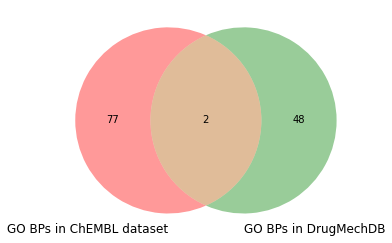

In [30]:
venn2_unweighted(
    [feas_gobps, bps],
    set_labels=['GO BPs in ChEMBL dataset', 'GO BPs in DrugMechDB']
)

Okay, yikes. Only two GO BPs are in the set from ChEMBL. Let's see how the overlap with the KGs is.

In [31]:
openbiolink_df = pd.read_csv(osp.join(KG_DIR, 'openbiolink_filtered.tsv'), sep='\t')
custom_df = pd.read_csv(osp.join(KG_DIR, 'customkg_filtered.tsv'), sep='\t')

In the `enrichment` notebook, we made a filtered mapping dataframe with GO annotations:

In [32]:
MAPPING_DIR = '../data/mappings'

In [33]:
filtered_df = pd.read_csv('../data/mappings/in_kg_go_terms.tsv', sep='\t')

In [34]:
filtered_df.head()

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
0,9606,ncbigene:2,GO:0001553,IEA,involved_in,luteinization,-,Process
1,9606,ncbigene:2,GO:0001869,IDA,involved_in,"negative regulation of complement activation, ...",12538697,Process
2,9606,ncbigene:2,GO:0002020,IBA,enables,protease binding,21873635,Function
3,9606,ncbigene:2,GO:0002020,IPI,enables,protease binding,7679575|18485748,Function
4,9606,ncbigene:2,GO:0002438,IEA,involved_in,acute inflammatory response to antigenic stimulus,-,Process


In [35]:
bps_in_kg = set(filtered_df['GO_ID'])

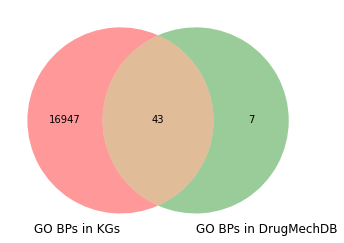

In [36]:
venn2_unweighted(
    [bps_in_kg, bps],
    set_labels=['GO BPs in KGs', 'GO BPs in DrugMechDB']
)

In [37]:
from matplotlib_venn import venn3_unweighted

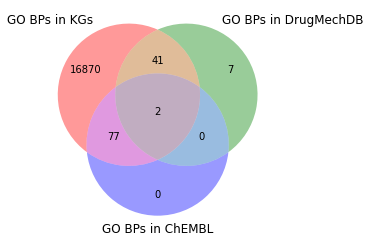

In [38]:
venn3_unweighted(
    [bps_in_kg, bps, feas_gobps],
    set_labels=['GO BPs in KGs', 'GO BPs in DrugMechDB', 'GO BPs in ChEMBL']
)

Cool, at least most of them exist in the KG! That is important because we know they are at least connected to a protein and can be mapped.

What about the drugs between DrugMechDB and the KG? First, we will have to map the drugs from DrugBank to PubChem.

In [37]:
# Get all the KG drugs:
obl_drugs = {d for d in openbiolink_df['source'] if 'pubchem.compound' in d}
custom_drugs = {d for d in custom_df['source'] if 'pubchem.compound' in d}

In [38]:
custom_drugs.update(obl_drugs)

I got a mapping file from [DrugBank](https://go.drugbank.com), which requires a private login/ license.

In [39]:
drugbank_mapping = pd.read_csv(osp.join(MAPPING_DIR, "drugbank_all_drug_links.csv.zip"))

In [40]:
drugbank_mapping.head()

,DrugBank ID,Name,CAS Number,Drug Type,KEGG Compound ID,KEGG Drug ID,PubChem Compound ID,PubChem Substance ID,ChEBI ID,PharmGKB ID,...,GenBank ID,DPD ID,RxList Link,Pdrhealth Link,Wikipedia ID,Drugs.com Link,NDC ID,ChemSpider ID,BindingDB ID,TTD ID
0,DB00001,Lepirudin,138068-37-8,BiotechDrug,NaN,D06880,NaN,46507011.0,NaN,PA450195,...,NaN,11916,http://www.rxlist.com/cgi/generic/lepirudin.htm,NaN,Lepirudin,http://www.drugs.com/cdi/lepirudin.html,NaN,NaN,NaN,DAP000541
1,DB00002,Cetuximab,205923-56-4,BiotechDrug,NaN,D03455,NaN,46507042.0,NaN,PA10040,...,J00228,13175,http://www.rxlist.com/cgi/generic3/erbitux.htm,NaN,Cetuximab,http://www.drugs.com/cdi/cetuximab.html,NaN,NaN,NaN,DNC000788
2,DB00003,Dornase alfa,143831-71-4,BiotechDrug,NaN,NaN,NaN,46507792.0,NaN,PA10318,...,M55983,650,http://www.rxlist.com/cgi/generic/pulmozyme.htm,NaN,Dornase_alfa,http://www.drugs.com/cdi/dornase-alfa.html,NaN,NaN,NaN,DAP000981
3,DB00004,Denileukin diftitox,173146-27-5,BiotechDrug,NaN,NaN,NaN,46506950.0,NaN,PA164750594,...,V01536,NaN,http://www.rxlist.com/cgi/generic2/denileukin.htm,NaN,Denileukin_diftitox,http://www.drugs.com/cdi/denileukin-diftitox.html,NaN,NaN,NaN,DAP001098
4,DB00005,Etanercept,185243-69-0,BiotechDrug,C07897,D00742,NaN,46506732.0,NaN,PA449515,...,M32315,12032,http://www.rxlist.com/cgi/generic/etanercept.htm,NaN,Etanercept,http://www.drugs.com/cdi/etanercept.html,NaN,NaN,NaN,DNC000605


Looks like we need the PubChem IDs without their prefixes:

In [41]:
cids = [cid.split(':')[1] for cid in custom_drugs]

The PubChem IDs are floats in the table. This is probably because there are NaNs.

In [42]:
drugbank_mapping.columns

Index(['DrugBank ID', 'Name', 'CAS Number', 'Drug Type', 'KEGG Compound ID',
       'KEGG Drug ID', 'PubChem Compound ID', 'PubChem Substance ID',
       'ChEBI ID', 'PharmGKB ID', 'HET ID', 'UniProt ID', 'UniProt Title',
       'GenBank ID', 'DPD ID', 'RxList Link', 'Pdrhealth Link', 'Wikipedia ID',
       'Drugs.com Link', 'NDC ID', 'ChemSpider ID', 'BindingDB ID', 'TTD ID'],
      dtype='object')

In [43]:
db2pc = {}
for dbid, pcid in zip(drugbank_mapping['DrugBank ID'], drugbank_mapping['PubChem Compound ID']):
    if not math.isnan(pcid):
        db2pc[dbid] = int(pcid)
    #else:
    #    db2pc[dbid] = pcid

In [44]:
# Get all drugs from DrugMechDB
dmdb_drugs = set(indications['db_id'])

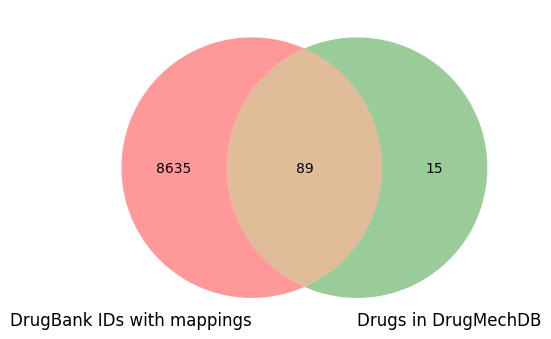

In [45]:
venn2_unweighted(
    [set(db2pc.keys()), dmdb_drugs],
    set_labels=['DrugBank IDs with mappings', 'Drugs in DrugMechDB']
)

15 of the drugs in DrugMechDB do not have mappings in this file.

For some, this is because these drugs are small proteins or don't have a discrete structure.

For others, the reference is just missing, so I looked them up manually:

In [46]:
db2pc['DB11254'] = '3610'
db2pc['DB00994'] = '8378'
db2pc['DB06762'] = '4826'
db2pc['DB11100'] = '204'
db2pc['DB11152'] = '119236'
db2pc['DB13676'] = '4257'

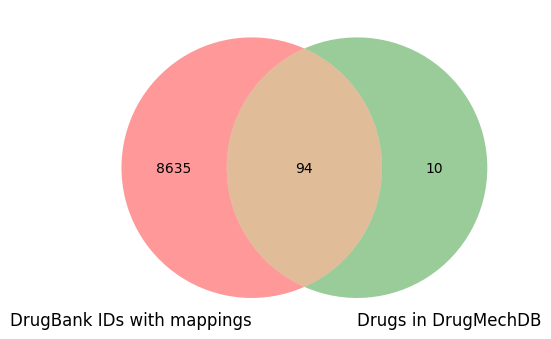

In [47]:
venn2_unweighted(
    [set(db2pc.keys()), dmdb_drugs],
    set_labels=['DrugBank IDs with mappings', 'Drugs in DrugMechDB']
)

In [48]:
dmdb_drug_pc_ids = {str(db2pc[d]) for d in set(db2pc.keys()).intersection(dmdb_drugs)}

In [49]:
len(dmdb_drug_pc_ids)

94

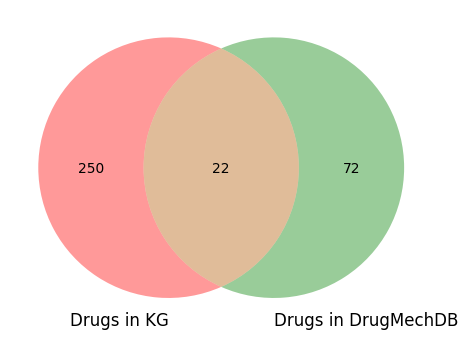

In [50]:
venn2_unweighted(
    [set(cids), dmdb_drug_pc_ids],
    set_labels=['Drugs in KG', 'Drugs in DrugMechDB']
)

Only 22 of those 94 are in the KG. Is it worth incorporating the 72 into the KG? Perhaps we can see whether their protein targets are already in the KG, and whether we need to incorporate them.

### Protein Overlap

First, let's get all the proteins from the paths and see how many of them are in the KG.

In [51]:
prots_in_kg = set(filtered_df['GeneID'])

In [52]:
dmdb_proteins = set()
for path in bp_paths:
    for node in path['nodes']:
        if node['label'] == 'Protein':
            dmdb_proteins.add(node['id'])

In [53]:
len(dmdb_proteins)

56

In [54]:
dmdb_proteins

{'MESH:D012338',
 'MESH:Q14145',
 'UniProt:O05131',
 'UniProt:O43497',
 'UniProt:O76074',
 'UniProt:P01148',
 'UniProt:P04083',
 'UniProt:P04150',
 'UniProt:P04585',
 'UniProt:P06401',
 'UniProt:P08546',
 'UniProt:P08588',
 'UniProt:P08908',
 'UniProt:P09917',
 'UniProt:P0A0H0',
 'UniProt:P0A298',
 'UniProt:P0A7J3',
 'UniProt:P0A7S3',
 'UniProt:P0C1U9',
 'UniProt:P10275',
 'UniProt:P10721',
 'UniProt:P11388',
 'UniProt:P11511',
 'UniProt:P14416',
 'UniProt:P14867',
 'UniProt:P16234',
 'UniProt:P19235',
 'UniProt:P20831',
 'UniProt:P22301',
 'UniProt:P23219',
 'UniProt:P23945',
 'UniProt:P23975',
 'UniProt:P25021',
 'UniProt:P31645',
 'UniProt:P35348',
 'UniProt:P35354',
 'UniProt:P35367',
 'UniProt:P35372',
 'UniProt:P43702',
 'UniProt:P44350',
 'UniProt:P47712',
 'UniProt:P48048',
 'UniProt:P48357',
 'UniProt:P54289',
 'UniProt:P55017',
 'UniProt:P71707',
 'UniProt:P72525',
 'UniProt:P9WGY7',
 'UniProt:Q01726',
 'UniProt:Q12791',
 'UniProt:Q16236',
 'UniProt:Q81VT3',
 'UniProt:Q8DR59'

If we look into those proteins, most have [UniProt](https://www.uniprot.org) IDs, but some are under [MeSH](https://www.nlm.nih.gov/mesh/meshhome.html) terms.

MESH:Q14145, can not even be found in the MeSH browser.

I will just look at the UniProt proteins then. I will need to map them to ncbi gene IDs first:

In [55]:
# get rid of MeSh terms:
dmdb_proteins = {p for p in dmdb_proteins if 'UniProt' in p}

In [56]:
def uniprot2ncbi(uniprot_ids):
    """Outputs a dictionary mapping from uniprot IDs to ncbi gene IDs.
    :param uniprot_ids: a list of uniprot IDs with UniProt: prefix
    :returns: dictionary with uniprot as keys as ncbi gene as values
    """
    up2ncbi = {up_id: None for up_id in uniprot_ids}
    for up_id in tqdm(uniprot_ids):
        up = up_id.split(':')[1]
        r = requests.get(f'https://rest.uniprot.org/uniprotkb/search?query={up}')
        xrefs = r.json()['results'][0]['uniProtKBCrossReferences']
        for xref in xrefs:
            if xref['database'] == 'GeneID':
                up2ncbi[up_id] = 'ncbigene:' + xref['id']
                break
    return up2ncbi

In [57]:
dmdb_prot_mappings = uniprot2ncbi(dmdb_proteins)

100%|█████████████████████████████████████████████████| 54/54 [00:18<00:00,  2.89it/s]


How many did not map?

In [58]:
len([i for i in dmdb_prot_mappings.values() if i == None])

8

How many in the KG?

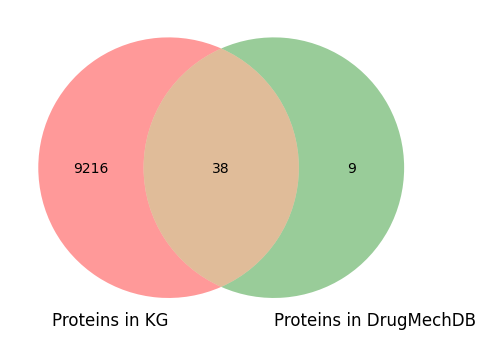

In [59]:
venn2_unweighted(
    [prots_in_kg, set(dmdb_prot_mappings.values())],
    set_labels=['Proteins in KG', 'Proteins in DrugMechDB']
)

Which one is not in the KG?

In [60]:
set(dmdb_prot_mappings.values()) - prots_in_kg

{None,
 'ncbigene:155348',
 'ncbigene:3920380',
 'ncbigene:45020152',
 'ncbigene:67415314',
 'ncbigene:67460217',
 'ncbigene:67463992',
 'ncbigene:887065',
 'ncbigene:888177'}

It's [Gag-Pol / Human immunodeficiency virus 1 ](https://www.ncbi.nlm.nih.gov/gene/?term=155348). Makes sense as it is actually a viral protein. How many BP paths is it involved in?

In [61]:
# TO BE FINISHED

The DrugBank recorded targets:

In [62]:
db_uniprot_mapping = pd.read_csv(osp.join(MAPPING_DIR, "drugbank_all_target_uniprot_links.csv.zip"))

In [63]:
db_uniprot_mapping.head()

,DrugBank ID,Name,Type,UniProt ID,UniProt Name
0,DB00001,Lepirudin,BiotechDrug,P00734,Prothrombin
1,DB00002,Cetuximab,BiotechDrug,P00533,Epidermal growth factor receptor
2,DB00002,Cetuximab,BiotechDrug,O75015,Low affinity immunoglobulin gamma Fc region re...
3,DB00002,Cetuximab,BiotechDrug,P02745,Complement C1q subcomponent subunit A
4,DB00002,Cetuximab,BiotechDrug,P02746,Complement C1q subcomponent subunit B


## Metapaths

Finally, let's explore the metapaths a bit.

There are two sheets for metapaths. One is the original metapaths:

In [64]:
metapaths = pd.read_excel(dm_db, 'metapaths')

In [65]:
metapaths.head()

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,Drug,INHIBITS,Protein,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Drug,INHIBITS,Protein,UP_REGULATES,Biological Process,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Drug,INHIBITS,Pathway,ASSOCIATED_WITH,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Drug,INHIBITS,Protein,PRODUCES,Compound Class,CAUSES,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


... and another is Biolink metapaths: 

`"Version 1.1.0 includes a new tab 'metapaths_biolink' where the majority of node and edge types have been mapped to entities and relationship slots in the biolink model."`

In [66]:
metapaths_biolink = pd.read_excel(dm_db, 'metapaths_biolink')

In [67]:
metapaths_biolink.head()

,n1,e1,n2,e2,n3,e3,n4,e4,n5,e5,n6,e6,n7,e7,n8
0,Drug,decreases activity of,Protein,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Drug,decreases activity of,Protein,positively regulates,BiologicalProcess,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Drug,decreases activity of,Protein,positively regulates,BiologicalProcess,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Drug,negatively regulates,Pathway,affects risk for,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Drug,decreases activity of,Protein,increases abundance of,NaN,causes,Disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I think we'll use the biolink-adjusted ones. How long are these metapaths, typically?

In [68]:
Counter([(row.count() - 1) / 2 for i, row in metapaths_biolink.iterrows()])

Counter({4.0: 55,
         3.0: 33,
         2.0: 13,
         5.0: 7,
         2.5: 5,
         3.5: 4,
         1.0: 3,
         4.5: 1,
         6.5: 1,
         6.0: 1})

This is pretty weird, since some of the metapaths have NaN in them. Otherwise, we wouldn't be getting anything other than integers for the path lengths.

What does NaN mean? Can it be any entity?

Maybe this is a problem with converting everything to Biolink- let's try the original DF:

In [69]:
len(metapaths)

123

In [70]:
Counter([(row.count() - 1) / 2 for i, row in metapaths.iterrows()])

Counter({4.0: 59, 3.0: 38, 2.0: 13, 5.0: 8, 1.0: 3, 7.0: 1, 6.0: 1})

For now, we aren't really using these metapaths, so I will conclude that exploration there.